# Anomaly Detection

## Methods Used in this Notebook:
- Using Residual Plot
- CART - Isolation Forest
- Forescating
- Clustering
- Autoencoders

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fbprophet import Prophet

from time import time
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('catfish.csv')
df.head()

,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239


In [3]:
df.shape

(324, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    324 non-null    object
 1   Total   324 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    324 non-null    datetime64[ns]
 1   Total   324 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.2 KB


In [6]:
df.describe()

,Total
count,324.000000
mean,19643.984568
std,5039.324331
min,8196.000000
25%,15764.000000
50%,19660.500000
75%,23604.500000
max,30485.000000


In [7]:
df.set_index('Date', inplace = True)

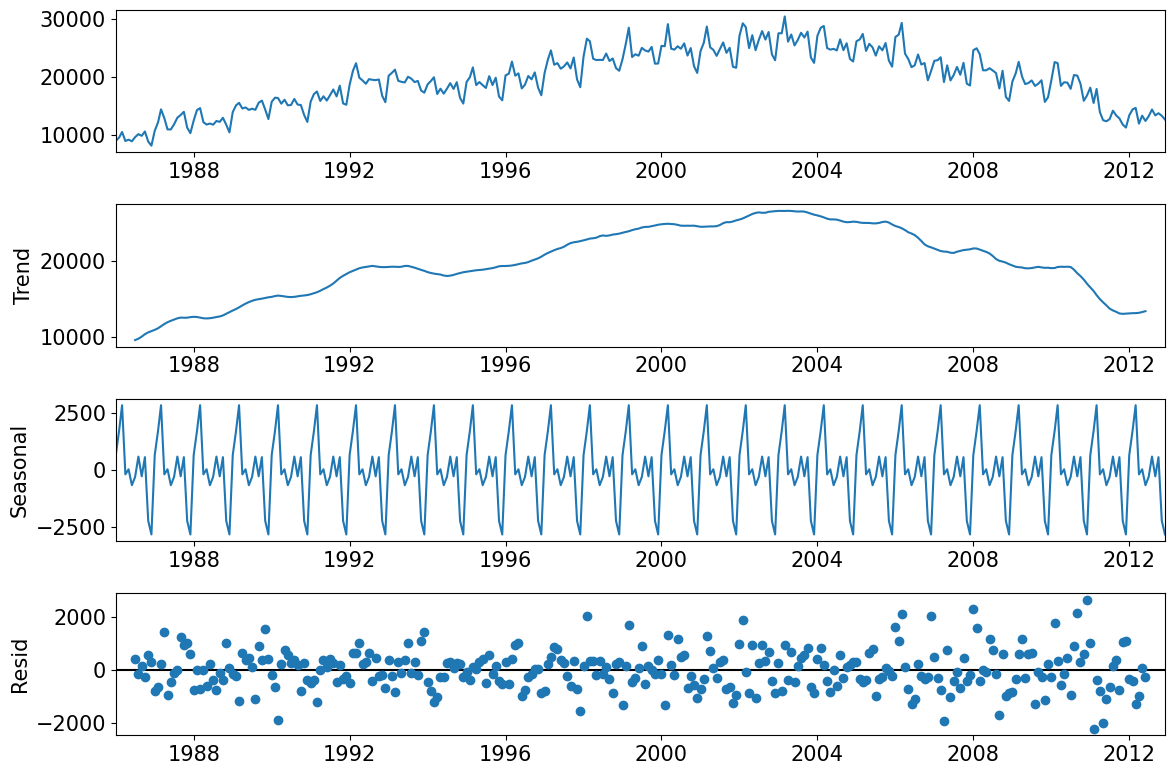

In [8]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)
result = seasonal_decompose(df,model='additive')
fig = result.plot()

### Currently, there are no outliers in the data, we will introduce outlier in the following section

## Introducing Outlier

- We will introduce anomoly for Dec 1998

In [9]:
 df.loc["1998-12-1"]['Total'] = 10000

In [10]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
df_limit = df[start_date:end_date]

In [11]:
df_limit.shape

(49, 1)

# Method 1 - Using Residual Plot

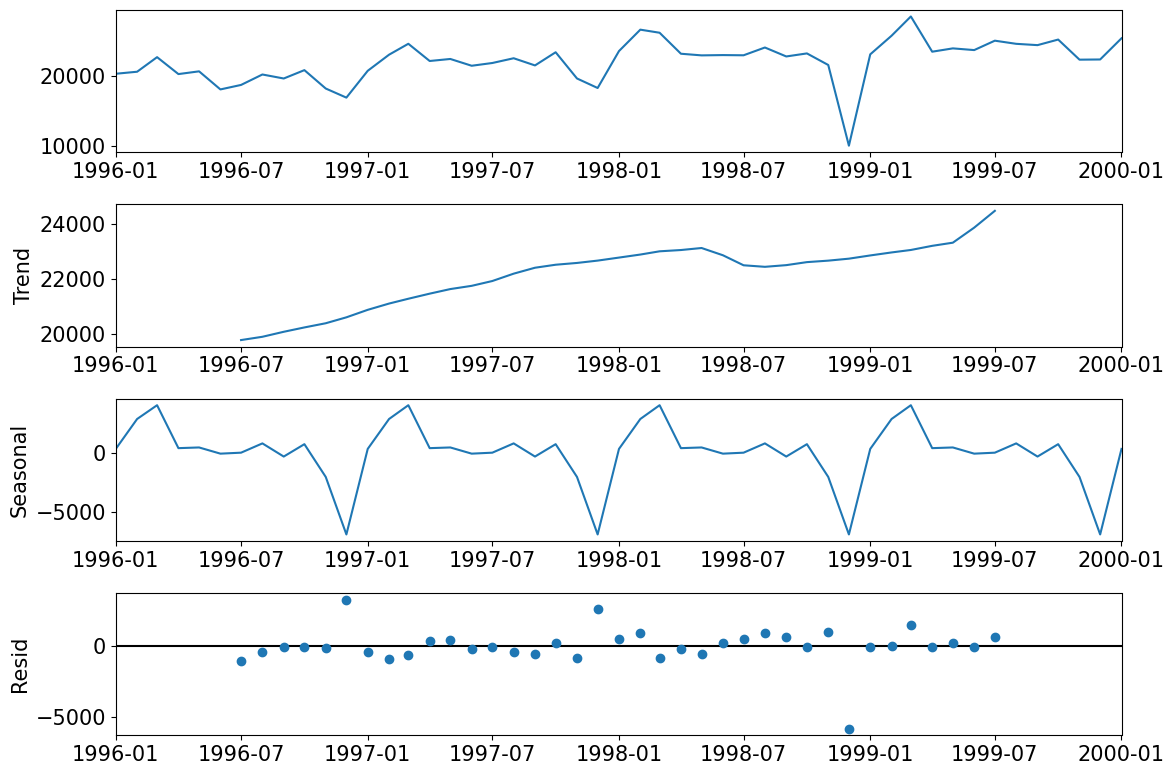

In [12]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)
result = seasonal_decompose(df_limit,model='additive')
fig = result.plot()

### Analysing the deviation of residual will help us find the anomaly

Text(0.5, 1.0, 'Residual Plot to Identify Deviation')

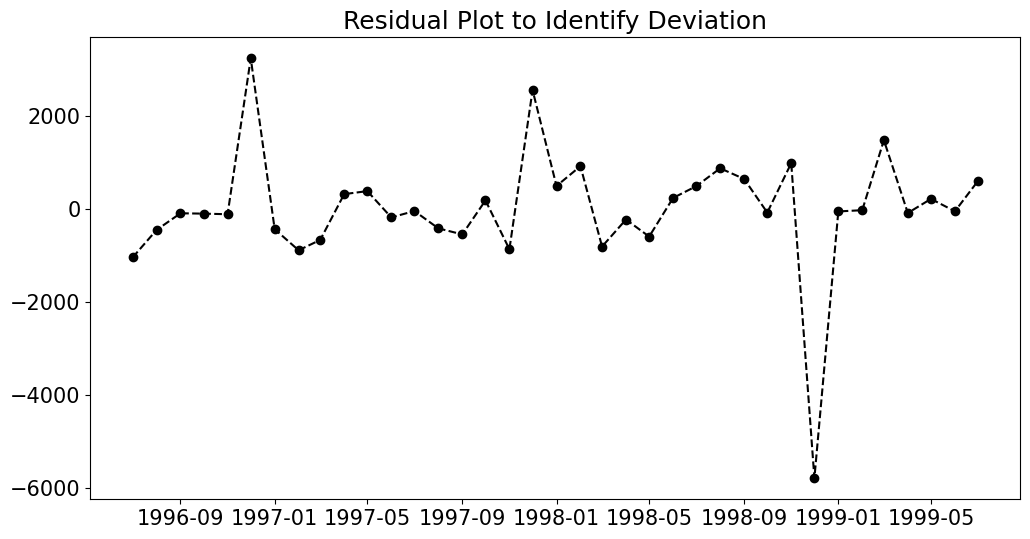

In [13]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
fig, ax = plt.subplots()
ax.plot_date(result.resid.index, result.resid.values, color='black',linestyle='--')
plt.title('Residual Plot to Identify Deviation')

### From the above residual plot, we can clearly see the deviation at Dec 1998

# Method 2 - CART

In [32]:
df = pd.read_csv('catfish.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace = True)

In [33]:
df_cart = df

In [34]:
outliers_fraction = float(.01)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cart.values.reshape(-1, 1))
data = pd.DataFrame(df_scaled)


In [35]:
data.head()

,0
0,-2.108695
1,-1.996999
2,-1.805805
3,-2.115054
4,-2.067952


In [36]:
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(contamination=0.01)

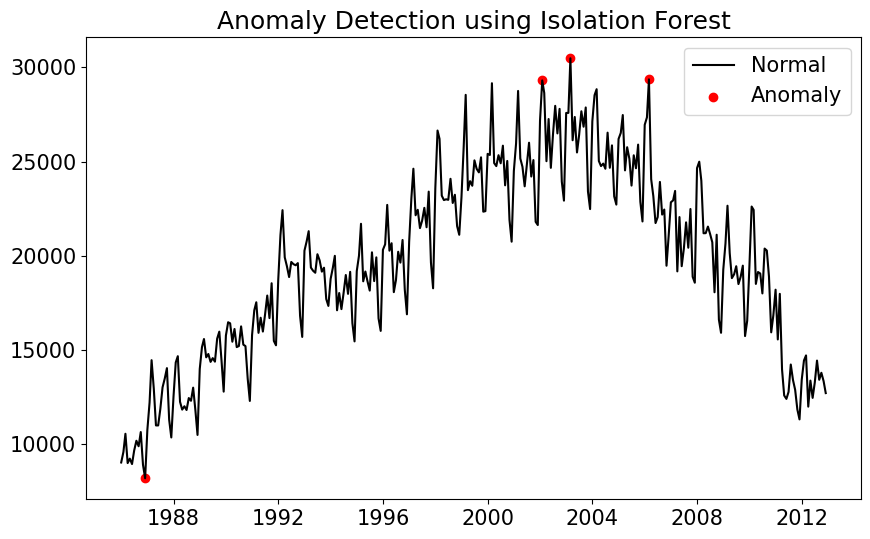

In [37]:
df_cart['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))
a = df_cart.loc[df_cart['anomaly'] == -1, ['Total']] #anomaly
ax.plot(df.index, df_cart['Total'], color='black', label = 'Normal')
ax.scatter(a.index, a['Total'], color='red', label = 'Anomaly')
plt.title('Anomaly Detection using Isolation Forest')
plt.legend()
plt.show()


### Observations
- There are anomalies in the initial years indicating that the algorithm is naive and it gets better as it sees more data.

- The contamination parameter can be adjusted to get better results

## Method 3 - Forecasting

In [41]:
df = pd.read_csv('catfish.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace = True)

In [42]:
train_prophet = pd.DataFrame(df)
train_prophet.reset_index(inplace=True)
train_prophet = train_prophet.rename(columns = {'Date': 'ds', 'Total': 'y'})
train_prophet.head()

,ds,y
0,1986-01-01,9034
1,1986-02-01,9596
2,1986-03-01,10558
3,1986-04-01,9002
4,1986-05-01,9239


## Training the Prophet Model and making predictions

In [43]:
my_model = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'additive', 
                interval_width = 0.99,
                changepoint_range = 0.8)

In [44]:
my_model.fit(train_prophet)

Initial log joint probability = -19.2598
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       690.771    0.00263734       226.444   2.002e-05       0.001      168  LS failed, Hessian reset 
      99       690.965    0.00242402       119.629           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       692.721   0.000201533       39.7073   3.034e-06       0.001      327  LS failed, Hessian reset 
     199       692.728    2.6297e-05       43.6482           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       692.729   1.94814e-07       60.1478   3.796e-09       0.001      413  LS failed, Hessian reset 
     223       692.729   4.70423e-08       37.7655      0.9139      0.9139      416   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

In [47]:
forecast = my_model.predict(train_prophet)
forecast['fact'] = train_prophet['y'].reset_index(drop = True)
forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].tail()

,ds,trend,yhat,yhat_lower,yhat_upper,fact
319,2012-08-01,13900.241742,13900.241742,9207.527116,18471.381447,14442
320,2012-09-01,13767.520500,13767.520500,9358.051890,18301.175392,13422
321,2012-10-01,13639.080589,13639.080589,9244.179835,18887.361561,13795
322,2012-11-01,13506.359347,13506.359347,8805.425945,18199.370248,13352
323,2012-12-01,13377.919435,13377.919435,8276.761856,18009.766847,12716


## Detect Anamolies

Based on the upper and lower threshold, we will detect the anomaly, i.e if the actual value is outside the interval range, it will be considered as anamoly

In [48]:
anomaly_df = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
anomaly_df['anomaly'] = 0

In [55]:
def anomaly_fn(fact, upper, lower):
    if fact>upper:
        return 1
    elif fact<lower:
        return -1
    else:
        return 0
                                      

In [58]:
anomaly_df['anomaly'] = anomaly_df.apply(lambda x: anomaly_fn(x['fact'], x['yhat_upper'], x['yhat_lower']), axis = 1)



In [59]:
anomaly_df['anomaly'].value_counts()

0    319
1      5
Name: anomaly, dtype: int64

In [69]:
def importance_anomaly(fact, upper, lower, anomaly):
    if anomaly == 1:
        return (fact-upper)/fact
    elif anomaly == -1:
        return (lower-fact)/fact
    else:
        return 0

In [70]:
anomaly_df['importance'] = anomaly_df.apply(lambda x: importance_anomaly(x['fact'], x['yhat_upper'], x['yhat_lower'], x['anomaly']), axis = 1)



In [71]:
anomaly_df['importance'] .value_counts()

0.000000    319
0.034355      1
0.009686      1
0.028316      1
0.018064      1
0.005866      1
Name: importance, dtype: int64

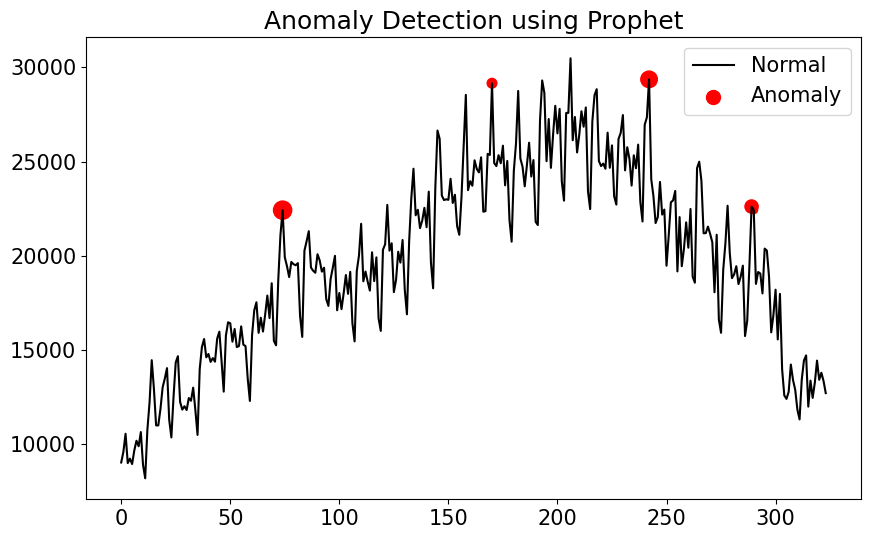

In [80]:

# visualization
fig, ax = plt.subplots(figsize=(10,6))
a = anomaly_df.loc[anomaly_df['anomaly'] == 1, ['fact', 'importance']] #anomaly
ax.plot(anomaly_df.index, anomaly_df['fact'], color='black', label = 'Normal')
ax.scatter(a.index, a['fact'], color='red', s = a['importance']*5000,label = 'Anomaly')
plt.title('Anomaly Detection using Prophet')
plt.legend()
plt.show()


# Method 4 - Clustering

### In this method, the data points that fall outside the defined clusters will be marked as anomalies

In [183]:
df_clus = pd.read_csv('TimeSeriesExpedia.csv')

In [184]:
df_clus.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,63,2013-05-23 11:56:25,14,100,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,90,2013-04-23 11:12:24,14,100,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,133,2013-03-14 11:27:28,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,148,2013-03-21 02:24:03,10,4,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,203,2013-01-03 20:48:24,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,1.0,0.0,14.0,0,NaN,0


In [185]:
df_clus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   srch_id                      54 non-null     int64  
 1   date_time                    54 non-null     object 
 2   site_id                      54 non-null     int64  
 3   visitor_location_country_id  54 non-null     int64  
 4   visitor_hist_starrating      3 non-null      float64
 5   visitor_hist_adr_usd         3 non-null      float64
 6   prop_country_id              54 non-null     int64  
 7   prop_id                      54 non-null     int64  
 8   prop_starrating              54 non-null     int64  
 9   prop_review_score            54 non-null     float64
 10  prop_brand_bool              54 non-null     int64  
 11  prop_location_score1         54 non-null     float64
 12  prop_location_score2         53 non-null     float64
 13  prop_log_historical_pr

In [186]:
data_clus = df_clus[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
data_clus.isnull().sum()

price_usd                   0
srch_booking_window         0
srch_saturday_night_bool    0
dtype: int64

In [187]:
wcss = []
ks = list(range(1,20))
for i in ks:
    model = KMeans(n_clusters = i)
    model.fit(data_clus)
    wcss.append(model.inertia_)
    

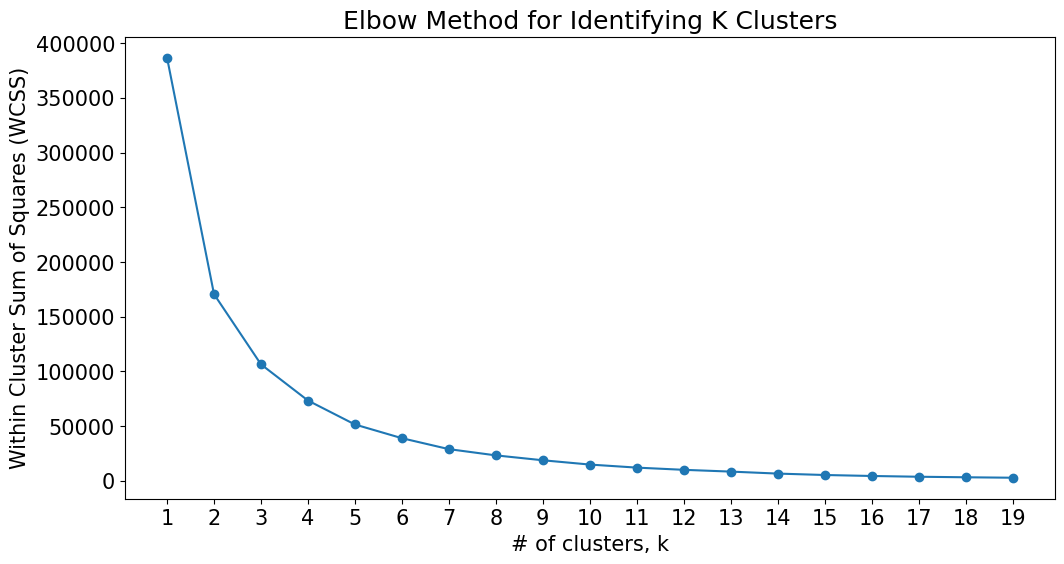

In [188]:
# Plot number of clusters (k) vs inertia for each model
plt.plot(ks, wcss, '-o')
plt.xlabel('# of clusters, k')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.xticks(ks)
plt.title('Elbow Method for Identifying K Clusters')
plt.show()

## Scaling and PCA

In [189]:
data_std = StandardScaler().fit_transform(data_clus)

In [190]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data_std)
PCA_components = pd.DataFrame(principalComponents)
print(pca.explained_variance_ratio_)

[0.52257177 0.32186023 0.155568  ]


### Since the first 2 components explains more than 80% of the variance, we will choose 2

In [191]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_std)
PCA_components = pd.DataFrame(principalComponents)

Text(0.5, 1.0, 'Variance Described by PCA Components')

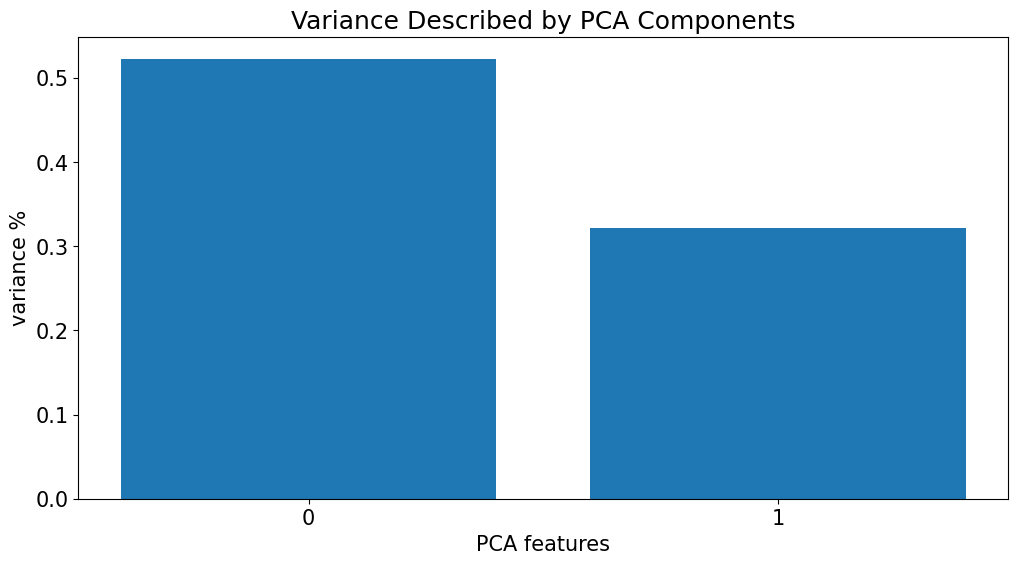

In [192]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.title('Variance Described by PCA Components')

In [193]:
# standardize these 2 new features
scaler = StandardScaler()
final_scaled = scaler.fit_transform(PCA_components)
data = pd.DataFrame(final_scaled)

In [194]:
data.shape

(54, 2)

In [195]:
wcss = []
ks = list(range(1,20))
for i in ks:
    model = KMeans(n_clusters = i)
    model.fit(data)
    wcss.append(model.inertia_)
    

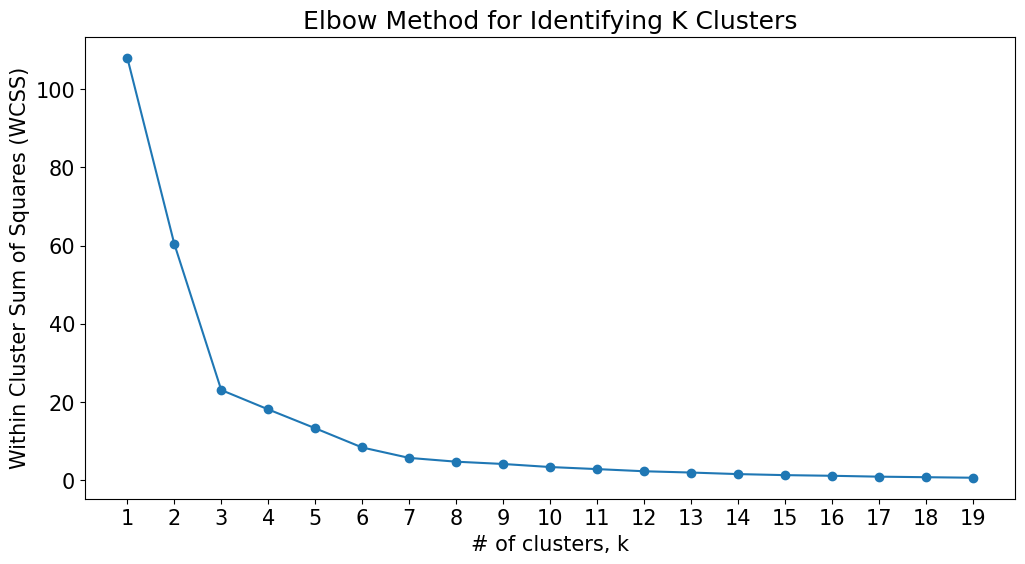

In [196]:
# Plot number of clusters (k) vs inertia for each model
plt.plot(ks, wcss, '-o')
plt.xlabel('# of clusters, k')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.xticks(ks)
plt.title('Elbow Method for Identifying K Clusters')
plt.show()

### From the above elbow curve, we see that the WCSS scores levels off after 10 clusters. We will choose n_clusters = 10 for our model

In [197]:
model = KMeans(n_clusters = 10)
model.fit(data)
df_clus['cluster'] = model.predict(data)
df_clus.index = data.index
df_clus['principal_feature1'] = data[0]
df_clus['principal_feature2'] = data[1]
df_clus['cluster'].value_counts()

7    12
0    12
2     8
6     7
1     4
9     3
4     3
5     2
8     2
3     1
Name: cluster, dtype: int64

### We will calcualte the distance between each point and its nearest centroid. The point which is farthest away will be considered as anomalies

In [198]:
model.cluster_centers_

array([[-0.88383193, -0.38838605],
       [ 1.79790244, -0.1642996 ],
       [-0.38295754,  0.58613336],
       [ 0.79027154,  2.37993352],
       [ 1.78608708, -1.47424969],
       [ 2.1010746 ,  2.33747284],
       [ 0.7100534 , -1.07924701],
       [-0.72062756, -0.06689755],
       [-0.05044418, -0.30271596],
       [-0.03153433,  2.31985523]])

In [199]:
np.array(df_clus[['principal_feature1','principal_feature2']].loc[0])

array([-0.67341271, -0.17700972])

In [200]:
distance = []
for i in range(len(df_clus)):
    x1 = np.array(df_clus[['principal_feature1','principal_feature2']].loc[i])
    x2 = model.cluster_centers_[model.labels_[i]-1]
    distance.append(np.linalg.norm(x1-x2))
len(distance)

distance = pd.Series(distance)

In [201]:
outliers_fraction = 0.1
number_of_outliers = int(outliers_fraction*len(data_clus))

##Choosing the top 5 points that are far away from the centroid
threshold = distance.nlargest(number_of_outliers).min()
threshold

3.946841160768532

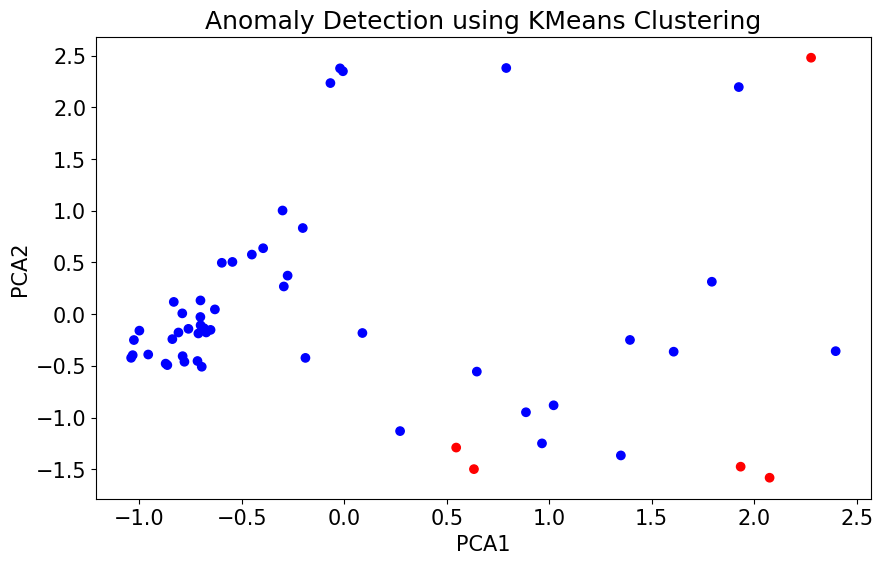

In [202]:
df_clus['anomaly1'] = (distance >= threshold).astype(int)
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df_clus['principal_feature1'], df_clus['principal_feature2'], c=df_clus["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Anomaly Detection using KMeans Clustering')
plt.show()

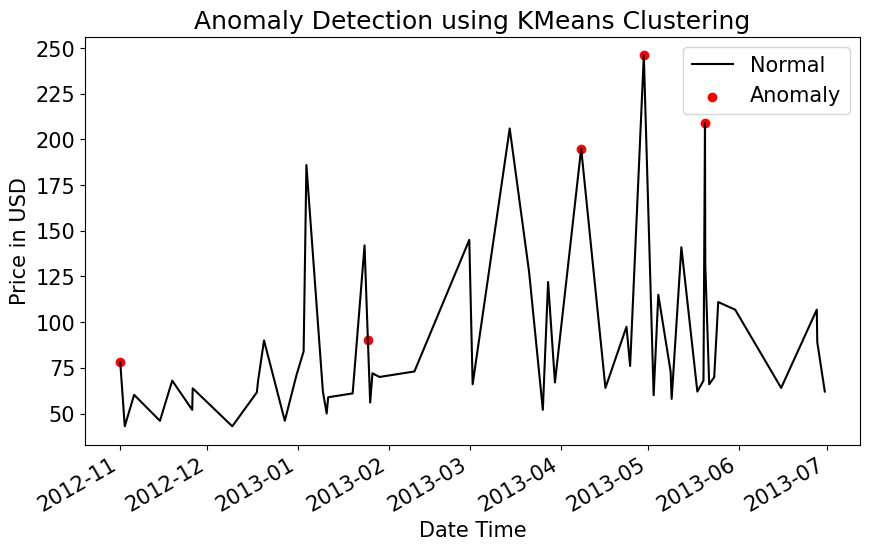

In [203]:
df_clus = df_clus.sort_values('date_time')
fig, ax = plt.subplots(figsize=(10,6))

a = df_clus.loc[df_clus['anomaly1'] == 1, ['date_time', 'price_usd']] #anomaly
ax.plot(pd.to_datetime(df_clus['date_time']), df_clus['price_usd'], color='k',label='Normal')
ax.scatter(pd.to_datetime(a['date_time']),a['price_usd'], color='red', label='Anomaly')

plt.xlabel('Date Time')
plt.ylabel('Price in USD')
plt.title('Anomaly Detection using KMeans Clustering')

plt.legend()
fig.autofmt_xdate()
plt.show()

### We can also use density based clustering methods like DBSCAN to identify outliers 

# Method 5 - Autoencoders

!pip install pyod

### Autoencoders are unsupervised method that does dimensionality reduction to identify anomalies

### We will generate synthetic data, introduce outliers, and perform autoencoding using PyOD module

In [211]:
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data


n_train = 500  # number of training points
n_test = 500  # number of testing points
n_features = 25 # Number of features
anomaly = 0.1  # percentage of outliers

X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features, 
    contamination=anomaly,random_state=42)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [212]:
print('Training dataset:', X_train.shape)
print('Testing dataset:', X_test.shape)

Training dataset: (500, 25)
Testing dataset: (500, 25)


In [215]:
print('Training Labels:', y_train.shape)
print('Testing Labels:', y_test.shape)

Training Labels: (500,)
Testing Labels: (500,)


In [207]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,5.440890,5.485244,5.441937,5.296010,5.375220,5.272512,5.393143,5.411316,5.300885,5.367348,...,5.442672,5.374014,5.420621,5.391860,5.346807,5.485004,5.488859,5.441123,5.485429,5.418011
std,2.029880,2.155810,2.415454,2.571129,2.193180,2.449828,2.176604,2.095211,2.324060,2.240309,...,2.161219,2.245469,2.109023,2.316132,2.350690,2.140052,1.954768,2.275125,2.116903,2.300803
min,-5.284349,-5.865349,-5.193635,-5.893605,-5.820504,-5.834134,-5.332311,-5.648855,-5.650783,-5.722804,...,-5.609059,-5.847133,-5.614430,-5.788890,-5.644877,-5.956723,-5.571137,-5.849422,-5.734011,-5.851083
25%,5.190666,5.301704,5.209820,5.288226,5.270821,5.105706,5.208934,5.210609,5.258809,5.208359,...,5.281306,5.242811,5.190773,5.240776,5.268707,5.251055,5.267625,5.287461,5.257954,5.357550
50%,5.855665,5.946100,5.986302,5.927738,5.867836,5.859637,5.873211,5.883152,5.845223,5.906188,...,5.930059,5.806567,5.852877,5.915529,5.912967,5.913614,5.943902,5.943550,5.893193,5.895461
75%,6.497205,6.534028,6.618617,6.478461,6.416190,6.431930,6.453833,6.435947,6.400170,6.446937,...,6.456431,6.421285,6.436216,6.538365,6.448544,6.519564,6.465284,6.557922,6.492351,6.470996
max,8.835758,8.499130,8.595721,8.433871,8.595193,8.049292,8.050780,8.189382,8.085415,8.347698,...,8.301906,8.378108,8.300299,8.917174,8.508880,8.531754,7.844304,8.452912,8.516677,8.467637


### We will perform scaling to make sure all the features are off same scales

In [208]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)

# Building and Autoencoder

## We will plot the data using PCA

In [217]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
PCA_components = pd.DataFrame(principalComponents)
PCA_components.columns=['PC1','PC2']

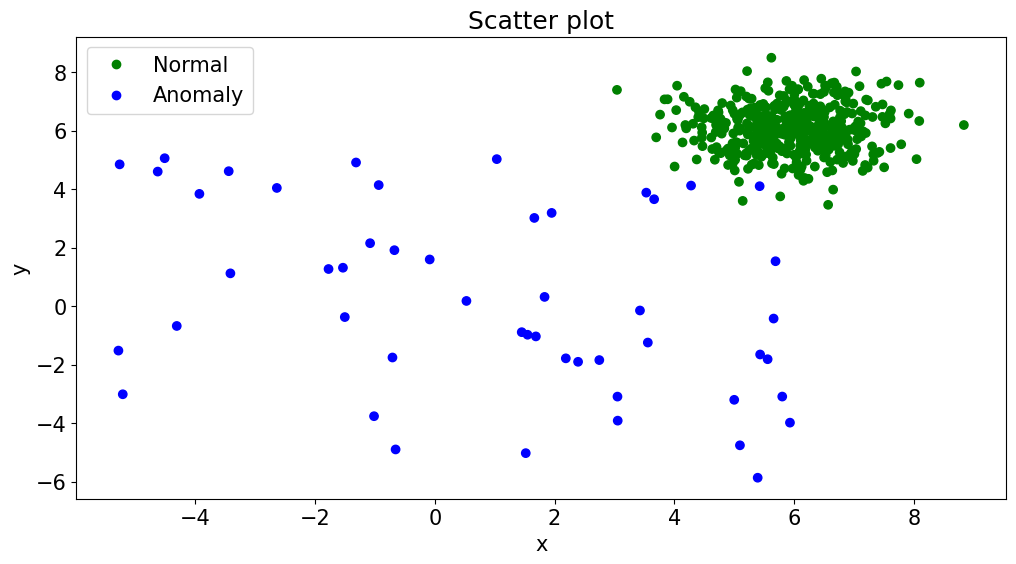

In [225]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

colors = ListedColormap(['g','b'])
sca = plt.scatter(X_train[0], X_train[1], c=y_train, alpha=1, cmap = colors)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
classes = ['Normal', 'Anomaly']
plt.legend(handles=sca.legend_elements()[0],labels=classes)
plt.show()

In [209]:
ae = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
ae.fit(X_train_scaled)

Metal device set to: Apple M1


2023-04-10 11:26:27.390463: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-10 11:26:27.391656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                650       
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                650       
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 5

2023-04-10 11:26:28.202093: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-10 11:26:28.516668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 2s 57ms/step - loss: 4.9030 - val_loss: 3.8781
Epoch 2/100
 4/15 [=======>......................] - ETA: 0s - loss: 3.8613

2023-04-10 11:26:30.580499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 21ms/step - loss: 3.5556 - val_loss: 3.2950
Epoch 3/100
15/15 [==============================] - 0s 20ms/step - loss: 2.9972 - val_loss: 2.9814
Epoch 4/100
15/15 [==============================] - 0s 22ms/step - loss: 2.6801 - val_loss: 2.7777
Epoch 5/100
15/15 [==============================] - 0s 21ms/step - loss: 2.4893 - val_loss: 2.6212
Epoch 6/100
15/15 [==============================] - 0s 20ms/step - loss: 2.3462 - val_loss: 2.4965
Epoch 7/100
15/15 [==============================] - 0s 20ms/step - loss: 2.2144 - val_loss: 2.3860
Epoch 8/100
15/15 [==============================] - 0s 20ms/step - loss: 2.1172 - val_loss: 2.2755
Epoch 9/100
15/15 [==============================] - 0s 23ms/step - loss: 2.0040 - val_loss: 2.1839
Epoch 10/100
15/15 [==============================] - 0s 21ms/step - loss: 1.9242 - val_loss: 2.1024
Epoch 11/100
15/15 [==============================] - 0s 21ms/step - loss: 1.8453 - val_loss: 2.0269
Epoch 12/1

15/15 [==============================] - 0s 20ms/step - loss: 1.0791 - val_loss: 1.2636
Epoch 84/100
15/15 [==============================] - 0s 20ms/step - loss: 1.0740 - val_loss: 1.2619
Epoch 85/100
15/15 [==============================] - 0s 19ms/step - loss: 1.0765 - val_loss: 1.2604
Epoch 86/100
15/15 [==============================] - 0s 20ms/step - loss: 1.0746 - val_loss: 1.2582
Epoch 87/100
15/15 [==============================] - 0s 20ms/step - loss: 1.0702 - val_loss: 1.2567
Epoch 88/100
15/15 [==============================] - 0s 23ms/step - loss: 1.0709 - val_loss: 1.2556
Epoch 89/100
15/15 [==============================] - 0s 20ms/step - loss: 1.0709 - val_loss: 1.2543
Epoch 90/100
15/15 [==============================] - 0s 19ms/step - loss: 1.0713 - val_loss: 1.2531
Epoch 91/100
15/15 [==============================] - 0s 19ms/step - loss: 1.0648 - val_loss: 1.2524
Epoch 92/100
15/15 [==============================] - 0s 21ms/step - loss: 1.0660 - val_loss: 1.2509
Epo

2023-04-10 11:27:00.840926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x2925859d0>, optimizer='adam',
      output_activation='sigmoid', preprocessing=True, random_state=None,
      validation_size=0.1, verbose=1)

In [227]:
# Get the outlier scores for the train data
y_train_scores = ae.decision_scores_  
y_train_scores.shape

(500,)

### Make prediction of anomaly scores on test data

In [229]:
y_test_scores = ae.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

16/16 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Histogram for AE Model Anomaly Scores')

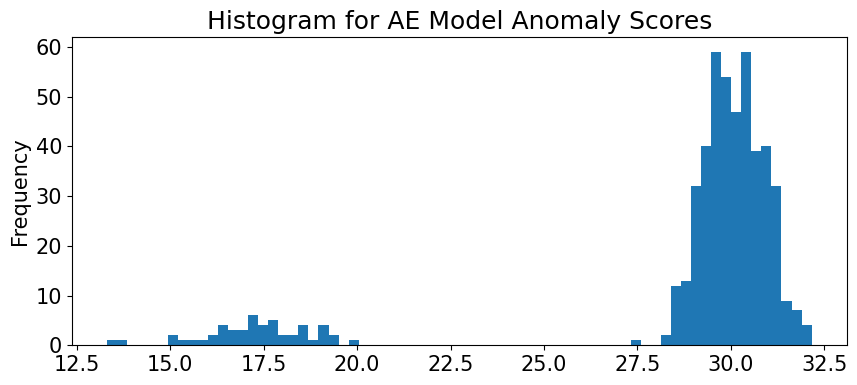

In [239]:
plt.figure(figsize=(10,4))
y_test_scores.plot(kind = 'hist', bins = 70)
plt.title("Histogram for AE Model Anomaly Scores")

### We can see that lower scores correscponds to outliers and higher score corresponds to normal data points


In [242]:
print('Model identified anomolies:', len(y_test_scores[y_test_scores<25]))

Model identified anomolies: 50


### The model was successfully able to identify the 50 anomalies

### Thus the antoencoders works well with higher dimensional data. However, since it is based on deep learning, it sufferes when there are too little data points.`

## References:

- https://www.projectpro.io/article/anomaly-detection-using-machine-learning-in-python-with-example/555
- https://thecleverprogrammer.com/2020/08/04/arima-model-in-machine-learning/
- https://neptune.ai/blog/anomaly-detection-in-time-series